# This is a replication of Lim's method

In [13]:
# Check GPU for Google Colab
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()
 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=1c1f9736e153b3284da8969d499abfae7a32fbdc7557fcd13a7085813b3813a0
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 14.0 GB  | Proc size: 15.9 GB
GPU RAM Free: 13667MB | Used: 2613MB | Util  16% | Total 16280MB


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import random
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.layers import Activation, BatchNormalization, ZeroPadding2D, Concatenate, Dropout, UpSampling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD, Adam, Adadelta
from keras.losses import binary_crossentropy
from sklearn import preprocessing
import os
import pickle
import matplotlib.pyplot as plt
plt.interactive(False)

from itertools import permutations
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.spatial import distance
from PIL import Image, ImageOps
import gc
import math
import time
import itertools
from operator import itemgetter

Using TensorFlow backend.


In [0]:
## CNN module as specified in the paper
def create_base_network(in_dims):
    """
    Base network to be shared.
    """
    model = Sequential()
 
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=(in_dims[0],in_dims[1],in_dims[2])))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D((2, 2), strides=3))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D((2, 2), strides=3))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D((2, 2), strides=3))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D((2, 2), strides=3))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (1, 1), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    
    model.add(Flatten(name='embeddings'))
    
    print(model.summary())
    
    return model

In [0]:
def compile_model(img_channel=1):
  print("Compiling model...")
  img_size = 112

  optim = Adadelta(lr=1.0, rho=0.95, epsilon=0.000001, decay=0.0) # as specified in the paper

  anchor_input = Input((img_size,img_size,img_channel, ), name='anchor_input')
  positive_input = Input((img_size,img_size,img_channel, ), name='positive_input')
  negative_input = Input((img_size,img_size,img_channel, ), name='negative_input')

  # Shared embedding layer for positive and negative items
  Shared_DNN = create_base_network([img_size,img_size,img_channel])

  encoded_anchor = Shared_DNN(anchor_input)
  encoded_positive = Shared_DNN(positive_input)
  encoded_negative = Shared_DNN(negative_input)

  merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

  model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
  model.compile(loss=triplet_loss, optimizer=optim)
  
  return model

In [0]:
def evaluate_triplet(X_test, Y_test):
  
#   X_test = [Negative_train, Positive_train, Anchor_train]
#   Y_test = np.zeros((Anchor_train.shape[0],1))
  
  pred = model.predict(x=X_test, verbose=1)
  
  # Split into anchor, a, and b sets
  total_lenght = pred.shape[1]
  pred_anchor = pred[:,0:int(total_lenght*1/3)]
  pred_a = pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
  pred_b = pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]
  
  
  # Normalize vectors as specified in the paper
  for i in range(len(pred_anchor)):
    if np.sum(pred_anchor[i]**2) >= 1:
      pred_anchor[i] = preprocessing.normalize([pred_anchor[i]], norm='l2')[0]
    if np.sum(pred_a[i]**2) >= 1:
      pred_a[i] = preprocessing.normalize([pred_a[i]], norm='l2')[0]
    if np.sum(pred_b[i]**2) >= 1:
      pred_b[i] = preprocessing.normalize([pred_b[i]], norm='l2')[0]

  
  result = []
  for i in range(pred.shape[0]):
    dist1 = distance.euclidean(pred_anchor[i], pred_a[i])
    dist2 = distance.euclidean(pred_anchor[i], pred_b[i])

    if dist1 < dist2:
      result.append(0)
    else:
      result.append(1)   
  
  accuracy = accuracy_score(Y_test, result)
  print("Evaluation accuracy: ", accuracy)

  return accuracy


In [0]:
## Create two plots; accuracy and loss
def save_plot(eval_name, fold_id, view_id):
  fig = plt.figure()

  # top
  ax1 = fig.add_subplot(2, 1, 1)
  ax1.plot(df_history['train_loss'])
  ax1.plot(df_history['val_loss'])
  ax1.set_xlabel("epoch")
  ax1.set_ylabel("loss")
  plt.legend(['train_loss', 'val_loss'], loc='upper right', fontsize='x-small')
  plt.title("Fold-"+str(fold_id)+", View-"+str(view_id))

  # bottom
  ax2 = fig.add_subplot(2, 1, 2)
  ax2.plot(df_history['val_acc'])
  ax2.set_xlabel("epoch")
  ax2.set_ylabel("accuracy")
  plt.legend(['val_accuracy'], loc='upper left', fontsize='x-small')

#   fig.show()
  fig.savefig("drive/My Drive/Saved_Images/CV_eval_img/" + eval_name + "/Fold-"+str(fold_id) + "-View-"+str(view_id))
  plt.close()

In [0]:
# def data_generator(fold_id,view_ids=[1,6,8]):  
#   ## Generate training/test data
#   df_train = pd.read_pickle("drive/My Drive/10CV_df/Lun_building/df_train_" + str(fold_id) + ".csv")
#   df_test = pd.read_pickle("drive/My Drive/10CV_df/Lun_building/df_test_" + str(fold_id) + ".csv")
# #   df_train = df_train.sample(frac=1).reset_index(drop=True)
# #   df_test = df_test.sample(frac=1).reset_index(drop=True)
#   df_train = df_train.reset_index(drop="True")
#   df_test = df_test.reset_index(drop="True")

#   ### Create image dataset for triplet learning 
#   img_size = 128
#   img_mode = "L" #["RGB", "L"]
#   img_path = "drive/My Drive/Style_data2_views/building/"

#   out_list = []
#   ################ Generate Training Data ################
#   name_list = ["query", "pos", "neg"]
#   data_length = len(df_train)

#   for k in range(0,3):
#     print("Generating training data", k+1, "/3...")
#     input_data = []
#     for i in range(data_length):
#       for j in view_ids:
#           data_id = df_train.loc[:,name_list[k]][i]
#           img_file = data_id + "_" + str(j) + ".png"
#           img = img_path + img_file
#           img = Image.open(img)
#           img = ImageOps.expand(img, border=30, fill=0)  # padding with 0s
#           img = img.convert(img_mode)
#           img = img.resize((img_size, img_size))
#           data = np.asarray(img)/255
          
#           # Randomly crop 112x112 images
#           for i in range(2):             # num of cropped images
#             rand1 = random.randrange(17)
#             rand2 = random.randrange(17)
#             data_crop = np.asarray(data[rand1:rand1+112, rand2:rand2+112])

#             input_data.append(data_crop)
#             input_data.append(np.fliplr(data_crop)) ## Flipped image

#     out_list.append(np.array(input_data))
    


#   ############### Generate Test Data #########################
#   data_length = len(df_test)

#   for k in range(0,3):
#     print("Generating test data", k+1, "/3...")
#     input_data = []
#     for i in range(data_length):
#       for j in view_ids:
#           data_id = df_test.loc[:,name_list[k]][i]
#           img_file = data_id + "_" + str(j) + ".png"
#           img = img_path + img_file
#           img = Image.open(img)
#           img = ImageOps.expand(img, border=25, fill=0) # padding with 0s
#           img = img.convert(img_mode)
#           img = img.resize((img_size, img_size))
#           data = np.asarray(img)/255
#           data_crop = np.asarray(data[8:120, 8:120]) # crop a image on the centre
#           input_data.append(data_crop)
          
#     out_list.append(np.array(input_data))

#   return out_list



In [0]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    
#     total_lenght = y_pred.shape.as_list()[-1]
    total_lenght = 512*3
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]
     
    # Normalize vectors as specified in the paper
    anchor = K.switch(K.greater_equal(K.sum(K.square(anchor)), 1), lambda: K.l2_normalize(anchor, axis=0), lambda: anchor)
    positive = K.switch(K.greater_equal(K.sum(K.square(positive)), 1), lambda: K.l2_normalize(positive, axis=0), lambda: positive)
    negative = K.switch(K.greater_equal(K.sum(K.square(negative)), 1), lambda: K.l2_normalize(negative, axis=0), lambda: negative)

    # distance between the anchor and the positive
    pos_dist = K.sqrt(K.sum(K.square(anchor-positive),axis=1))

    # distance between the anchor and the negative
    neg_dist = K.sqrt(K.sum(K.square(anchor-negative),axis=1))

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)

    return loss

In [0]:
def evaluate_triplet_vote(X_test, Y_test, num_views):
  
  pred = model.predict(x=X_test, verbose=1)
  
  # Split into anchor, a, and b sets
  total_lenght = pred.shape[1]
  pred_anchor = pred[:,0:int(total_lenght*1/3)]
  pred_a = pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
  pred_b = pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]
  
  # Normalize vectors as specified in the paper
  for i in range(len(pred_anchor)):
    if np.sum(pred_anchor[i]**2) >= 1:
      pred_anchor[i] = preprocessing.normalize([pred_anchor[i]], norm='l2')[0]
    if np.sum(pred_a[i]**2) >= 1:
      pred_a[i] = preprocessing.normalize([pred_a[i]], norm='l2')[0]
    if np.sum(pred_b[i]**2) >= 1:
      pred_b[i] = preprocessing.normalize([pred_b[i]], norm='l2')[0]
  
  
  result_tmp = []
  result = []
  for i in range(pred.shape[0]):
    dist1 = distance.euclidean(pred_anchor[i], pred_a[i])
    dist2 = distance.euclidean(pred_anchor[i], pred_b[i])

    if dist1 < dist2:
      result_tmp.append(0)
    else:
      result_tmp.append(1)
      
    if len(result_tmp)==num_views:
      if (sum(result_tmp) < math.ceil(num_views/2)):
        result.append(0)
      else:
        result.append(1)
      
      result_tmp=[]

  print("Voting evaluation accuracy: ", accuracy_score(Y_test[0:int(len(Y_test)/num_views)], result))

  return accuracy_score(Y_test[0:int(len(Y_test)/num_views)], result)


In [0]:
def data_generator2(fold_id,view_ids=[1,2,3], num_triplets=5):  
  ## Generate training/test data
  df_train = pd.read_pickle("drive/My Drive/10CV_df/Lun_building/df_train_" + str(fold_id) + ".csv")
  df_test = pd.read_pickle("drive/My Drive/10CV_df/Lun_building/df_test_" + str(fold_id) + ".csv")

  df_train = df_train.reset_index(drop="True")
  df_test = df_test.reset_index(drop="True")

  print("Training original size: ", df_train.shape)
  print("Test original size: ", df_test.shape)
  ### Create image dataset for triplet learning 
  img_size = 128
  img_mode = "L" #["RGB", "L"]
  img_path = "drive/My Drive/Style_data2_views/building/"
  
  ### All combinations of views ###
  view_comb = []
  for i in itertools.product(view_ids, repeat=3):
    view_comb.append(i)

  out_list = [] # final output
  ################ Generate Training Data ################
  name_list = ["query", "pos", "neg"]
  data_length = len(df_train)
  
  print("Generating training data...")
  
  out = [[], [], []]
  cur_triplets_all = []
  
  for i in range(data_length):
    cur_triplets_sub = []
    rand_list = random.sample(range(0, len(view_comb)), num_triplets)
    for j in range(num_triplets):
      view_out = view_comb[rand_list[j]]           # randomly selected view combination
      cur_triplets_sub.append(view_out)
      
      for k in range(0,3):
          data_id = df_train.loc[:,name_list[k]][i]
          img_file = data_id + "_" + str(view_out[k]) + ".png"
          img = img_path + img_file
          img = Image.open(img)
          img = ImageOps.expand(img, border=30, fill=0)  # padding with 0s
          img = img.convert(img_mode)
          img = img.resize((img_size, img_size))
          data = np.asarray(img)/255
          
          # Randomly crop 112x112 images
          rand1 = random.randrange(17)
          rand2 = random.randrange(17)
          data_crop = np.asarray(data[rand1:rand1+112, rand2:rand2+112])

          # Flip image by 50% probability
          rand_flip = random.randrange(2)
          if rand_flip==0:
            out[k].append(data_crop)
          else:
            out[k].append(np.fliplr(data_crop)) ## Flipped image
            
    cur_triplets_all.append(cur_triplets_sub)
    
    if i%5 == 0:
      print("\r{0}".format(i), "/", data_length,  end="")
    
  out_list.append(np.array(out[0]))
  out_list.append(np.array(out[1]))
  out_list.append(np.array(out[2]))
    


  ############### Generate Test Data #########################
  data_length = len(df_test)

  for k in range(0,3):
    print("Generating test data", k+1, "/3...")
    out345 = []
    for i in range(data_length):
      for j in view_ids:
          data_id = df_test.loc[:,name_list[k]][i]
          img_file = data_id + "_" + str(j) + ".png"
          img = img_path + img_file
          img = Image.open(img)
          img = ImageOps.expand(img, border=25, fill=0) # padding with 0s
          img = img.convert(img_mode)
          img = img.resize((img_size, img_size))
          data = np.asarray(img)/255
          data_crop = np.asarray(data[8:120, 8:120]) # crop a image on the centre
          out345.append(data_crop)
          
    out_list.append(np.array(out345))

  return [out_list, np.array(cur_triplets_all)]


In [0]:
## Regenerate training set every 10 epoch as proposed in the paper 

def regenerate_set(fold_id, train_set, cur_triplets, num_triplets, view_ids=[1,2,3]):
  margin = 0.2 # margin for gap criteria
#   print("Current:", cur_triplets)
  
  df_train = pd.read_pickle("drive/My Drive/10CV_df/Lun_building/df_train_" + str(fold_id) + ".csv").reset_index(drop="True")
  
  ### Create image dataset for triplet learning 
  img_size = 128
  img_mode = "L" #["RGB", "L"]
  img_path = "drive/My Drive/Style_data2_views/building/"
  
  print("=========== Regenerating training set ===========")
  
  #########################  Select 50% of view combinations from each triplet to retain  ##################################
  Anchor_train_all = train_set[0]
  Positive_train_all = train_set[1]
  Negative_train_all = train_set[2]
  pred = model.predict(x=[Anchor_train_all,Positive_train_all,Negative_train_all],verbose=1)
  
  total_width = pred.shape[1]
  data_length = len(pred)

  pred_a = pred[:,int(total_width*1/3):int(total_width*2/3)]
  pred_b = pred[:,int(total_width*2/3):int(total_width*3/3)]
  
  dist_pos_neg = np.sqrt(np.sum(np.power(pred_a - pred_b, 2),axis=1))

  df_dist = pd.DataFrame()
  df_dist["dist"] = dist_pos_neg
  index_retain = []
  index_cur = []
  for i in range(0, data_length, num_triplets):
    df_dist_sub = df_dist.iloc[i:i+num_triplets]
    df_dist_sub = df_dist_sub.sort_values(by="dist", ascending=False)
    index_retain.append(df_dist_sub.head(math.floor(num_triplets/4)).index.values.tolist())
    index_retain.append(df_dist_sub.tail(math.floor(num_triplets/4)).index.values.tolist())
    index_cur.append(df_dist_sub.index.values.tolist()) # used later
  
  cur_triplets_flat = list(itertools.chain.from_iterable(cur_triplets))
  cur_triplets_flat = [l.tolist() for l in cur_triplets_flat]

  index_retain = list(itertools.chain.from_iterable(index_retain))
  index_retain.sort()
  print("index_retain: ", index_retain)
  print(np.array(index_retain).shape)
  print(Anchor_train_all.shape)
  Anchor_train_retain = Anchor_train_all[index_retain]
  Positive_train_retain = Positive_train_all[index_retain]
  Negative_train_retain = Negative_train_all[index_retain]

  remaining_triplets = np.array(list(itertools.chain.from_iterable(np.array(cur_triplets_flat)[index_retain]))).reshape(-1, math.floor(num_triplets/4)*2, 3).tolist()

  print("\nRemaining 50% length:", len(Anchor_train_retain))
#   print("Remaining:", remaining_triplets)
  
  
  ###################################     Select new 50% of view combinations for each triplet    ############################################
  # All combinations of views
  view_comb = []
  new_triplets = []
  Anchor_train_new = []
  Positive_train_new = []
  Negative_train_new = []
  for i in itertools.product(view_ids, repeat=3):
    view_comb.append(i)
  view_comb = np.array(view_comb)
  print("view_comb shape: ", view_comb.shape)
  for i in range(int(data_length/num_triplets)):
    new_triplets_sub = [item for item in view_comb.tolist() if item not in cur_triplets[i].tolist()]
    new_triplets.append(new_triplets_sub)

  # Compute the distance of all the view combinations that are not in the current triplet
  name_list = ["query", "pos", "neg"]
  
  for i in range(int(data_length/num_triplets)):
    print("\r{0}".format(i), "/", int(data_length/num_triplets),  end="")
    out_new_triplets = [[], [], []]
    for j in range(len(new_triplets[i])):
      view_out = new_triplets[i][j]
      for k in range(0,3):
          data_id = df_train.loc[:,name_list[k]][i]
          img_file = data_id + "_" + str(view_out[k]) + ".png"
          img = img_path + img_file
          img = Image.open(img)
          img = ImageOps.expand(img, border=30, fill=0)  # padding with 0s
          img = img.convert(img_mode)
          img = img.resize((img_size, img_size))
          data = np.asarray(img)/255
          
          # Randomly crop 112x112 images
          rand1 = random.randrange(17)
          rand2 = random.randrange(17)
          data_crop = np.asarray(data[rand1:rand1+112, rand2:rand2+112])

          # Flip image by 50% probability
          rand_flip = random.randrange(2)
          if rand_flip==0:
            out_new_triplets[k].append(data_crop)
          else:
            out_new_triplets[k].append(np.fliplr(data_crop)) ## Flipped image
     
    # Generate triplets for all view combinations
    Anchor_train_all = out_new_triplets[0]
    Positive_train_all = out_new_triplets[1]
    Negative_train_all = out_new_triplets[2]

    # add a new dimension
    Anchor_train_all = np.array(Anchor_train_all)[:, :, :, np.newaxis]
    Positive_train_all = np.array(Positive_train_all)[:, :, :, np.newaxis]
    Negative_train_all = np.array(Negative_train_all)[:, :, :, np.newaxis]
    pred = model.predict(x=[Anchor_train_all,Positive_train_all,Negative_train_all],verbose=0)

    data_length_new_triplets = len(pred)

    pred_anchor = pred[:,0:int(total_width*1/3)]
    pred_a = pred[:,int(total_width*1/3):int(total_width*2/3)]
    pred_b = pred[:,int(total_width*2/3):int(total_width*3/3)]

    dist_pos = np.sqrt(np.sum(np.power(pred_anchor-pred_a, 2),axis=1))
    dist_neg = np.sqrt(np.sum(np.power(pred_anchor-pred_b, 2),axis=1))
    dist_diff = dist_neg - dist_pos

    df_dist = pd.DataFrame()
    df_dist["dist"] = dist_diff
    if  len(df_dist[df_dist["dist"] >= margin]) >= math.ceil(num_triplets/2):
      df_dist = df_dist[df_dist["dist"] >= margin]
      rand_index = random.sample(range(0, len(df_dist)), math.ceil(num_triplets/2))
      rand_index.sort()
      new50_index = df_dist.iloc[rand_index].index
    else:
      new50_index = df_dist.sort_values('dist', ascending=False).head(math.ceil(num_triplets/2))["dist"].index.tolist()
      new50_index.sort()
      
    Anchor_train_new.append(Anchor_train_all[new50_index[0],:,:,:])
    Anchor_train_new.append(Anchor_train_all[new50_index[1],:,:,:])
    Positive_train_new.append(Positive_train_all[new50_index[0],:,:,:])
    Positive_train_new.append(Positive_train_all[new50_index[1],:,:,:])
    Negative_train_new.append(Negative_train_all[new50_index[0],:,:,:])
    Negative_train_new.append(Negative_train_all[new50_index[1],:,:,:])
    new_triplets[i] = [new_triplets[i][s] for s in new50_index]

    
  remaining_triplets_flat = list(itertools.chain.from_iterable(remaining_triplets))
  new_triplets_flat = list(itertools.chain.from_iterable(new_triplets))
  
  cur_triplets_flat = list(itertools.chain.from_iterable(cur_triplets))
  cur_triplets_flat = [l.tolist() for l in cur_triplets_flat]

  print("\nNew 50% length: ", len(Anchor_train_new))

  Anchor_train_all_new = []
  Positive_train_all_new = []
  Negative_train_all_new = []
  new_triplets_all = []
  if len(Anchor_train_retain) < len(Anchor_train_new):
    j = 0
    for i in range(len(Anchor_train_retain)):
      Anchor_train_all_new.append(Anchor_train_retain[i])
      Anchor_train_all_new.append(Anchor_train_new[j])
      Anchor_train_all_new.append(Anchor_train_new[j+1])
      Positive_train_all_new.append(Positive_train_retain[i])
      Positive_train_all_new.append(Positive_train_new[j])
      Positive_train_all_new.append(Positive_train_new[j+1])
      Negative_train_all_new.append(Negative_train_retain[i])
      Negative_train_all_new.append(Negative_train_new[j])
      Negative_train_all_new.append(Negative_train_new[j+1])
      new_triplets_all.append(remaining_triplets_flat[j+1])
      new_triplets_all.append(new_triplets_flat[j+1])
      new_triplets_all.append(new_triplets_flat[j+1])
      j += 2
  else:
    for i in range(len(Anchor_train_retain)):
      Anchor_train_all_new.append(Anchor_train_retain[i])
      Anchor_train_all_new.append(Anchor_train_new[i])
      Positive_train_all_new.append(Positive_train_retain[i])
      Positive_train_all_new.append(Positive_train_new[i])
      Negative_train_all_new.append(Negative_train_retain[i])
      Negative_train_all_new.append(Negative_train_new[i])
      new_triplets_all.append(remaining_triplets_flat[j+1])
      new_triplets_all.append(new_triplets_flat[j+1])
    
    if i%50 == 0:
      print("\r{0}".format(i), "/", len(Anchor_train_retain),  end="")
      
  new_triplets_all = np.array(new_triplets_all).reshape(-1, num_triplets, 3)
                              
  print("Anchor_train_all_new shape:", np.array(Anchor_train_all_new).shape)
  return [[np.array(Anchor_train_all_new), np.array(Positive_train_all_new), np.array(Negative_train_all_new)], new_triplets_all]

# 10-fold-cross-validation

In [11]:
# %%capture
# import warnings
# warnings.filterwarnings("ignore")

## Multi-view version
## Training using all views

# Time
start = time.time()

##### 10-fold cross-validation ###########
for k in range(1,11):
  
  print("==================== Fold:", k, "/10 ===================")
  ## Generate k th fold
#   views = [0,2,4,6,8,10,12,14]
  views = [0,4,8,12]
  num_triplets = 12   # number of view combinations to generate for each triplet
  generated_data, cur_triplets = data_generator2(k,view_ids=views, num_triplets=num_triplets)
  Anchor_train_all = generated_data[0]
  Positive_train_all = generated_data[1]
  Negative_train_all = generated_data[2]
  # Use for RGB mode
  Anchor_train_all = Anchor_train_all[:, :, :, np.newaxis]
  Positive_train_all = Positive_train_all[:, :, :, np.newaxis]
  Negative_train_all = Negative_train_all[:, :, :, np.newaxis]

  Anchor_test_all = generated_data[3]
  Positive_test_all = generated_data[4]
  Negative_test_all = generated_data[5]
  # Use for RGB mode
  Anchor_test_all = Anchor_test_all[:, :, :, np.newaxis]
  Positive_test_all = Positive_test_all[:, :, :, np.newaxis]
  Negative_test_all = Negative_test_all[:, :, :, np.newaxis]


  Y_dummy1 = np.zeros((Anchor_train_all.shape[0],1))
  Y_dummy2 = np.zeros((Anchor_test_all.shape[0],1))

  train_length =int(Anchor_train_all.shape[0]/3)
  test_length =int(Anchor_test_all.shape[0]/3)
  
  num_epoch = 300
  
  ## Complie model
  model = compile_model(img_channel=1)

  df_history = pd.DataFrame(columns=['train_loss','val_loss','train_acc','val_acc'])
  for i in range(1,num_epoch+1):
    print("Epoch:",i,"/",num_epoch)
    
    # Regenerate training set every 10 epoch
    if i%10==0 and i>0:
      [Anchor_train_all, Positive_train_all, Negative_train_all], cur_triplets = regenerate_set(fold_id=k,
                                                                                                train_set=[Anchor_train_all, Positive_train_all, Negative_train_all],
                                                                                                cur_triplets=cur_triplets,
                                                                                                num_triplets=num_triplets,
                                                                                                view_ids=views)
      
    
    
    val_acc = evaluate_triplet(X_test = [Negative_test_all, Positive_test_all, Anchor_test_all], 
                                Y_test = np.zeros((Anchor_test_all.shape[0],1)))
    train_acc = evaluate_triplet(X_test = [Negative_train_all, Positive_train_all, Anchor_train_all], 
                                Y_test = np.zeros((Anchor_train_all.shape[0],1)))
    
#     evaluate_triplet_vote(X_test = [Negative_test_all, Positive_test_all, Anchor_test_all], 
#                                 Y_test = np.zeros((Anchor_test_all.shape[0],1)), num_views=len(views))
    
    history= model.fit(x=[Anchor_train_all, Positive_train_all, Negative_train_all], y=Y_dummy1,
                       validation_data=([Anchor_test_all,Positive_test_all,Negative_test_all],Y_dummy2),
                batch_size=64, epochs=1, verbose=1, shuffle=True)

    df_history = df_history.append(pd.DataFrame([history.history['loss'], history.history['val_loss'], [train_acc], [val_acc]],
                                                index=['train_loss','val_loss','train_acc','val_acc']).T)
    df_history = df_history.reset_index(drop="Ture")

    # elapsed time
    elapsed_time = time.time() - start
    print("Elapsed time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)), "\n")
    
  save_plot("Lun_building", fold_id=k, view_id=1)
  
  gc.collect()
  
  # Save a list of accuracy
  df_history.to_csv("drive/My Drive/MultiviewAccuracy_10CV/Lun_building/df_log_" + str(k) + ".csv")

==================== Fold: 1 /10 ===================
Training original size:  (636, 3)
Test original size:  (30, 3)
Generating training data...
635 / 636Generating test data 1 /3...
Generating test data 2 /3...
Generating test data 3 /3...
Compiling model...












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 112, 112, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0        

IndexError: ignored

In [12]:
gc.collect()

0

In [0]:
df_train = pd.read_pickle("drive/My Drive/10CV_df/Lun_building/df_train_1.csv")
df_test = pd.read_pickle("drive/My Drive/10CV_df/Lun_building/df_test_1.csv")

In [0]:
df_history.to_csv("drive/My Drive/MultiviewAccuracy_10CV/Lun_building/df_log_1.csv")

In [0]:
## Read saved accuracy log
pd.read_csv("drive/My Drive/MultiviewAccuracy_10CV/Lun_building/df_log_1.csv")

,Unnamed: 0,train_loss,val_loss,train_acc,val_acc
0,0,0.236780,0.565798,0.479953,0.483333
1,1,0.246455,0.531563,0.488994,0.466667
2,2,0.242638,0.560275,0.490959,0.466667
3,3,0.240937,0.545839,0.500393,0.416667
4,4,0.239942,0.549002,0.493711,0.450000


In [0]:
# Check reversed duplicates
df_tmp = df_train.copy()
print("df_tmp:", df_tmp.shape)
df_reversed = df_tmp.loc[:,["query","neg","pos"]].copy()
df_reversed = df_reversed.rename(columns={"pos":"neg", "neg":"pos"})
df_concat = pd.concat([df_tmp, df_reversed])
df_concat = df_concat.reset_index(drop=True)
print(int(df_concat.shape[0]))
df_concat = df_concat.drop_duplicates(keep='first')

print(int(df_concat.shape[0])-int(df_tmp.shape[0]))


df_tmp: (246, 3)
492
246


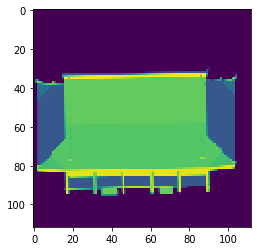

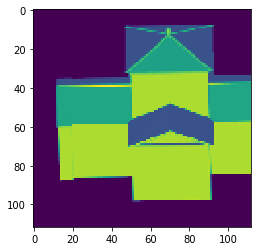

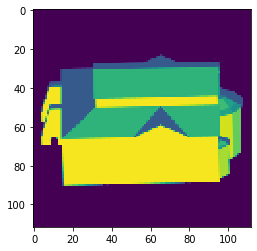

In [0]:
id = 0
data = Anchor_train_all[id][:,:,0]
# plt.imshow(data, cmap="gray")
plt.imshow(data)
plt.show()
data = Positive_train_all[id][:,:,0]
plt.imshow(data)
plt.show()
data = Negative_train_all[id][:,:,0]
plt.imshow(data)
plt.show()

In [0]:
# Evaluate on test data
# Anchor_test = input_data2_test
# Positive_test = input_data1_test
# Negative_test = input_data3_test
y_true = np.zeros((Anchor_test.shape[0],1))

pred = model.predict(x=[Anchor_test,Positive_test,Negative_test],verbose=1)

105/105 [==============================] - 1s 7ms/step


In [0]:
# Evaluate on training data
# Anchor = input_data2_train
# Positive = input_data1_train
# Negative = input_data3_train
y_true = np.zeros((Anchor.shape[0],1))

pred = model.predict(x=[Anchor_train,Positive_train,Negative_train],verbose=1)

702/702 [==============================] - 19s 28ms/step


In [0]:
# Split into anchor, a, and b sets
total_lenght = pred.shape[1]
pred_anchor = pred[:,0:int(total_lenght*1/3)]
pred_a = pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
pred_b = pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]
pred_a.shape

y_pred = []
for i in range(pred.shape[0]):
  dist_pos = distance.euclidean(pred_anchor[i], pred_a[i])
  dist_neg = distance.euclidean(pred_anchor[i], pred_b[i])
  print("Triplet", i, ":")
  print("dist_pos", dist_pos)
  print("dist_neg", dist_neg)
  print("---------------------------------")
  if dist_pos < dist_neg:
    y_pred.append(0)
  else:
    y_pred.append(1)   
    

print(accuracy_score(y_true, y_pred))


NameError: ignored

In [0]:
df_test = pd.read_pickle("drive/My Drive/10CV_df/Lun_building/df_test_1.csv")

# Generate empeddings for each object

In [0]:
## This model takes one object and outputs a embedding.
model=Model(inputs=model.get_layer("model_3").get_input_at(0),outputs=model.get_layer("model_3").get_output_at(0))

In [0]:
pred_cat1 = model.predict(x=Anchor,verbose=1)
pred_cat2 = model.predict(x=Positive,verbose=1)

702/702 [==============================] - 6s 9ms/step


In [0]:
query = pred_cat1[0]
df_dist = pd.DataFrame()
for i in range(pred_cat2.shape[0]):
  dist = distance.euclidean(query, pred_cat2[i])
  df_dist = df_dist.append(pd.DataFrame([dist]))
  print("Sample", i, ":")
  print("dist", dist)
df_dist = df_dist.reset_index(drop="True")

Sample 0 :
dist 11.942307472229004
Sample 1 :
dist 9.089716911315918
Sample 2 :
dist 5.0141496658325195
Sample 3 :
dist 11.207891464233398
Sample 4 :
dist 11.485407829284668
Sample 5 :
dist 11.594229698181152
Sample 6 :
dist 10.215923309326172
Sample 7 :
dist 8.77670955657959
Sample 8 :
dist 11.207891464233398
Sample 9 :
dist 9.089716911315918
Sample 10 :
dist 9.005356788635254
Sample 11 :
dist 8.812785148620605
Sample 12 :
dist 10.139031410217285
Sample 13 :
dist 11.737712860107422
Sample 14 :
dist 12.618820190429688
Sample 15 :
dist 6.905245780944824
Sample 16 :
dist 10.506524085998535
Sample 17 :
dist 12.860376358032227
Sample 18 :
dist 3.7555344104766846
Sample 19 :
dist 15.70533275604248
Sample 20 :
dist 9.249247550964355
Sample 21 :
dist 9.054219245910645
Sample 22 :
dist 10.1978759765625
Sample 23 :
dist 11.168105125427246
Sample 24 :
dist 14.29787540435791
Sample 25 :
dist 9.054219245910645
Sample 26 :
dist 5.6047210693359375
Sample 27 :
dist 8.992192268371582
Sample 28 :
dist 

In [0]:
df_dist.sort_values(by=0, ascending="True")

,0
18,3.755534
269,3.755534
103,3.755534
539,3.755534
633,4.329094
34,4.514034
251,4.514034
204,4.514034
234,4.514034
47,4.894937
